
## MED 5

# Metody ograniczenia wariancji modelu

Poszukując modelu regresji, czy klasyfikacji staramy się, by powstały estymator posiadał porządane statystycznie cechy: był zgodny, nieobciążony i najbardziej efektywny. W rzeczywistości trudno jest pogodzić dwie ostatnie własności. Przez brak obciążenia (ang.bias) rozumie się bowiem jak najlepsze dopasowanie do danych uczących. Przez największą efektywność rozumie się zwykle jak najmniejszy błąd estymacji dla zbioru testowego (każdego innego niż uczący) - najmniejszą wariancję modelu. Dla rzeczywistych zbiorów danych, na ogół, im mniejsze jest obciążenie, tym jest większa wariancja modelu i odwrotnie. Z uwagi jednak na fakt, iż celem dla którego powstaje model estymatora, jest jak najskuteczniejsze jego działanie dla nowych danych (innych niż uczące), przy tworzeniu modelu stosuje się metody, które kosztem zwiększenia obciążenia, zmniejszają wariancję modelu. W praktyce jest to osiągane przez poszukiwanie, w procesie uczenia,  modelu na tyle prostego by właściwie odwzorowywać trend, niekoniecznie idealnie dopasowującego się do danych zbioru uczącego.  

Zwiększając liczbę cech modelu oraz tworząc nowe zmienne opisujące zwiększa się zwykle jego wariancja. Widać to wyraźnie w przypadku zastosowania regresji wielomianowej. Zwiększanie stopnia wielomianu opisującego trend naszych danych zwiększane zostają współczynniki stojące przy kolejnych potęgach, co pozwala na dokładne dopasowanie modelu do danych uczących, jednak kosztem zwiększenia jego wariancji. Mimo iż obciążenie modelu z punktu widzenia danych uczących spada do zera, to tracimy jego zdolności uogólnienia (błąd estymacji wartości na podstawie zbioru testowego rośnie), co oznacza przeuczenie/nadmierne dopasowanie (ang. overfitting) naszego modelu.

Sposobem na redukcję stopnia przeuczenia/nadmiernego dopasowania modelu, a zatem ograniczenia jego wariancji, w przypadku regresji wielomianowej, są techniki regularyzacji. Generalnie mamy dwie możliwości działania:

1. Redukujemy wpływ cech nieznaczących na model tj. pozostawiamy wszystkie cechy ale w modelu realny wpływ na wyjście mają jedynie cechy znaczące - działa jeśli mamy dużo cech, z których każda skorelowana jest z wyjściem (regularyzacja Tichonowa, regresja grzbietowa - ang. ridge regression).
       
2. Redukujemy liczbę cech na jeden z trzech sposobów:

    a) selekcja manualna - używamy ważniejszych cech (w przypadku unormowanych wartości atrybutów opisujących będą to cechy, przy których wartość modułu współczynnika jest najwyższa)    
    
    b) używamy algorytmu do wyboru cech modelu (metoda zachłanna - analizujemy które cechy najlepiej minimalizują sumę kwadratu błędów)
    
    c) używamy metody regularyzacji eliminującej zbędne cechy (metoda lasso). 

Regresja grzebietowa i Lasso to efektywne techniki zwykle stosowane do tworzenia oszczędnych modeli w obecności „dużej” liczby funkcji. Tutaj „duże” może zwykle oznaczać jedną z dwóch rzeczy:

1. Wystarczająco duży, aby zwiększyć tendencję modelu do nadmiernego dopasowania (tak niskie, jak 10 zmiennych może powodować nadmierne dopasowanie)
    
2. Wystarczająco duży, aby powodować wyzwania obliczeniowe. W przypadku nowoczesnych systemów taka sytuacja może wystąpić w przypadku milionów lub miliardów cech.

Chociaż metoda grzebietowa i Lasso mogą wydawać się bardzo do siebie  podobne, dzięki specyficznym własnościom ich praktyczne zastosowania różnią się znacznie. Działają one poprzez karanie wielkości współczynników cech oraz minimalizowanie błędu między przewidywanymi a rzeczywistymi obserwacjami. Kluczowa różnica polega na sposobie przypisywania kary do współczynników:

* Regresja grzbietowa (ridge regression, regularyzacja Tichonowa):
        Dokonuje normalizacji L2, tj. Dodaje karę równą kwadratowi wielkości współczynników
        Cel minimalizacji = LS Obj + α * (suma kwadratów współczynników)
* Regresja lasso:
        Dokonuje normalizacji L1, tj. Dodaje karę równoważną wartości bezwzględnej wielkości współczynników
        Cel minimalizacji = LS Obj + α * (suma wartości bezwzględnych współczynników)

„LS Obj” odnosi się do „celu najmniejszych kwadratów”, tj. Celu regresji liniowej bez regularyzacji.

**Celem tego laboratorium jest zapoznanie się z działaniem metod regularyzacji i dobru cech modelu**.


Materiały pomocnicze, lekkie (wideo) wprowadzenia do :

* [Ridge regression](https://www.youtube.com/watch?v=Q81RR3yKn30)
* [Metody lasso](https://www.youtube.com/watch?v=NGf0voTMlcs)
* [i połączenie obu (elastic net)](https://www.youtube.com/watch?v=1dKRdX9bfIo)

Na początek - wczytanie bibliotek oraz wygenerowanie zbioru danych:

In [54]:
# Wczytaj bilbioteki podstawowe
import math 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [55]:
# Wczytaj biblioteki potrzebne do zajęć
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

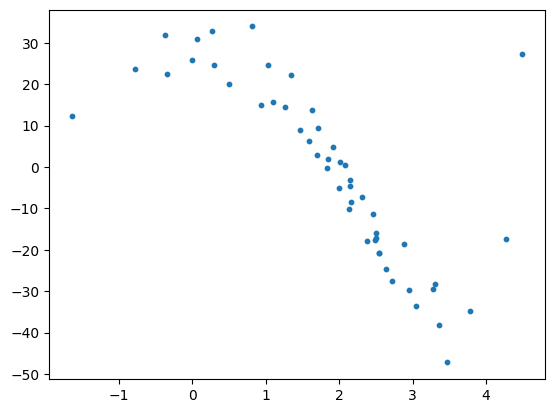

In [56]:
np.random.seed(5)
x = 2 - 3 * np.random.normal(0, 0.5, 50)
y = 30 + x - 5 * (x ** 2) - 2 * (x ** 3)+ 0.15 * (x ** 5)  + np.random.normal(-3, 5, 50)
plt.scatter(x,y, s=10)
plt.show()

### Zadanie 1 - regresja grzbietowa (ridge regression)

Zadanie polega na znalezieniu wielomianu $\hat{f}(x)$ postaci:

$$\hat{f}(x)=\omega_0+\omega_1 x^1+\omega_2x^2+ … +\omega_n x^n,$$

który mimo wysokiej złożoności modelu nie powoduje nadmiernego dopasowania do danych uczących poprzez zastosowanie regularyzacji L2.

Chcemy by nasza funkcja kosztu C($\omega$) miała postać:

$$C_{ridge}(\omega)=\sum_{i=0}^{k-1}\left(\hat{f}(x_i)−y_i\right)^2+\lambda \sum_{j=1}^n{\omega^2_j},$$

gdzie $i$ oznacza numer obserwacji, a $j$ kolejność współczynnika.

Wtedy rozwiązanie naszego równania wyzaczającego współczynniki wygląda w następujący sposób:

$$ \omega=\left(X^T X + \lambda \begin{bmatrix}
0 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 \\ 
0 & 0 & \ddots & 0\\ 
0 & 0 & 0  & 1 \\ 
\end{bmatrix}\right) ^{-1} X^Ty $$

**Należy pamiętać, że wyrazu wolnego nie poddajemy regularyzacji !**

A zatem - do dzieła!!!

W ramach pierwszej części zadania należy napisać funkcję wyznaczającą współczynniki $\omega$ wielomianowej funkcji regresji zgodnie z powyższym wzorem.

In [72]:
# Standardizing 'x'
x_mean = np.mean(x)
x_std = np.std(x)

# Standardization formula: (x - mean) / std
x_standardized = (x - x_mean) / x_std


In [75]:
# Napisz funkcję dopasowującą model regresji wielomianowej z regularyzacją L2 
# (wykorzystując rozwiązanie równania normalnego)
def regresja_L2(X, y, lamb, stopien_wielomianu):
    # Pomnaz macierze X.T X + lambda I i odwroc macierz
    # w = [X.T X + lambda I]^-1 X.T y

    

    identity_array = np.identity(stopien_wielomianu + 1)
    identity_array[0, 0] = 0

    inv_array = np.linalg.inv(np.dot(X.T, X) + lamb * identity_array)
    second_array = np.dot(inv_array, X.T)
    w = np.dot(second_array, y)
    
    return w


def create_X_matrix(deg, data):
    n = len(data)
    X = np.zeros((n, deg + 1))

    for i in range(n):
        for j in range(deg+1):
            X[i, j] = data.iloc[i, 0] ** j

    return X  

Poprawne (lub nie) działanie powyższej funkcji należy sprawdzić rysując jej wykres na wykresie punktowym zbioru danych

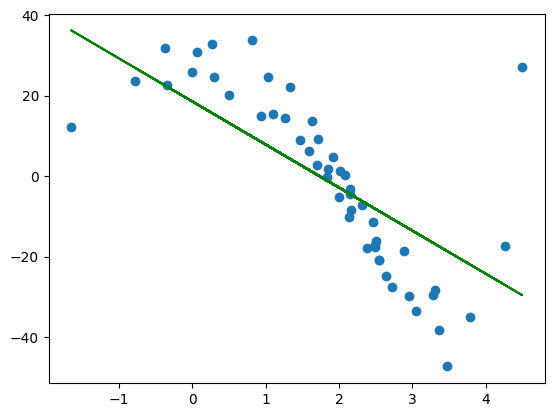

In [88]:
stopien_wielomianu = 1
X = create_X_matrix(stopien_wielomianu, pd.DataFrame(x_standardized))

w = regresja_L2(X, y, 10, stopien_wielomianu=stopien_wielomianu)

# Rysowanie wykresu 
plt.scatter(x, y)
values = np.dot(X,w)
plt.plot(x, values , c='green')
plt.show()

Podobnie jak wiele innych metod uczenia maszynowego, także i metoda regresji grzbietowej została zaimplementowana w jednym z pakietów języka Python. W kolejnym kroku nalezy znaleźć stosowną funkcję oraz porównać wyniki jej działania z własną funkcją.

[-11.43048248]


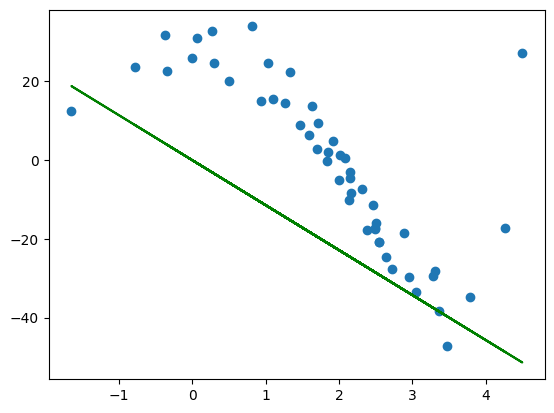

In [49]:
# miejsce na kod
# ridge regression in sklearn
ridge = Ridge(alpha=10)
ridge.fit(x.reshape(-1, 1), y)
print(ridge.coef_)
plt.scatter(x, y)
plt.plot(x, ridge.coef_*x, c='green')

In [ ]:
# moja regresja grzbietowa poradzila sobie lepiej niz sklearnowa (jest lepiej dopasowana do danych poczatkowych)

Celem wyznaczenia funkcji regresji na całym zbiorze, tak jak to miało miejsce powyżej, było praktyczne sprawdzenie jej działania. W przypadku, gdy uzyskany model estymatora miałby być zastosowany do estymacji wartości wyjściowej dla nieznanych wartości wejściowych (a zwykle tak to właśnie wygląda), oryginalny zbiór danych powinien zostac podzielony na zbiór uczący i testowy.

In [95]:
# Ze zbioru danych wydzielamy zbiór testowy zawierający 20% danych.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)




Do oceny modelu w procesie uczenia stosuje się często walidację krzyżową. W omawianym przypadku wyróżnia się dwa parametry metody - stopień wielomianu funkcji regresji oraz parametr $\lambda$. Zwykle pierwszy z nich jest ustalany a-priori, zaś drugi podlega weryfikacji poprzez wykonanie walidacji krzyżowej estymatorów dla różnych jego wartości. 

Korzystając z walidacji krzyżowej (5-krotny wybór zbioru) na zbiorze treningowym napisz funkcję, która dla wielomianu stopnia 15 narysuje wykres średniego błędu uczenia i średniego błędu walidacji, jak również wykres przedstawiający wartości współczynników modelu w funkcji zmiany parametru regularyzacji $\lambda=[0, 0.01, 0.02, 0.04, 0.08, \cdots, 10]$. Można przyjąć, że $\lambda_{a+1}=24\lambda_a$. Można skorzystać z funkcji [cross_validation](https://scikit-learn.org/stable/modules/cross_validation.html) lub [Search_Grid_CV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

c:\Users\seksc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.76184e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\seksc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.76006e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\seksc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.90754e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\seksc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.12751e-23): result may not be accurate.
  return linalg.solve

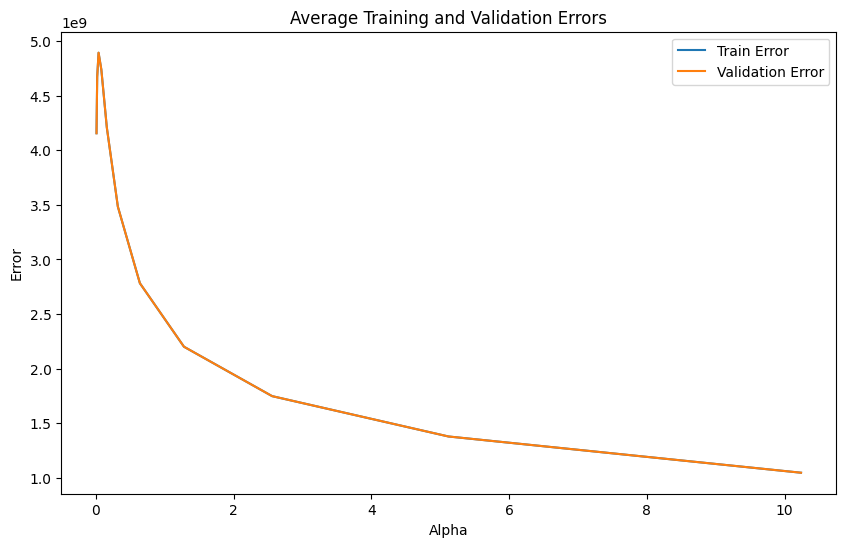

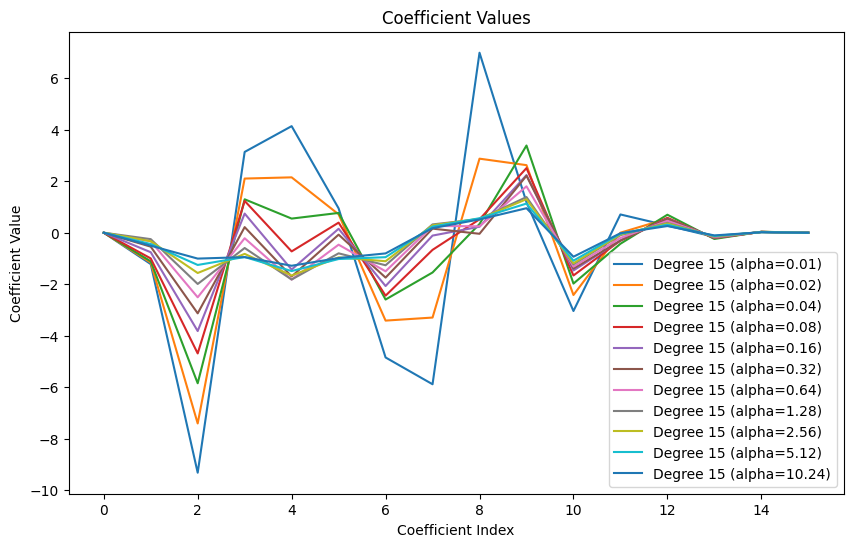

In [107]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def plot_errors_and_coefficients(X, y, degree, alphas):
    train_errors = []
    val_errors = []
    coefficients = []

    for alpha in alphas:         
        X_poly = create_X_matrix(degree, pd.DataFrame(X))
        ridge = Ridge(alpha=alpha)
        scores = cross_val_score(ridge, X_poly, y, cv=5, scoring='neg_mean_squared_error')
        train_errors.append(-np.mean(scores))
        val_errors.append(-np.mean(scores))
        coefficients.append(ridge.fit(X_poly, y).coef_)

    # Plot errors
    plt.figure(figsize=(10, 6))
    plt.plot(alphas, train_errors, label='Train Error')
    plt.plot(alphas, val_errors, label='Validation Error')
    plt.xlabel('Alpha')
    plt.ylabel('Error')
    plt.title('Average Training and Validation Errors')
    plt.legend()
    plt.show()


    plt.figure(figsize=(10, 6))
    for i, alpha in enumerate(alphas):
        plt.plot(range(degree+1), coefficients[i], label=f'Degree {degree} (alpha={alpha})')
    plt.xlabel('Coefficient Index')
    plt.ylabel('Coefficient Value')
    plt.title('Coefficient Values')
    plt.legend()
    plt.show()

# Example usage
degree = 15
alphas = np.array([0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.24])
plot_errors_and_coefficients(X_train, y_train, degree, alphas)





**Pytania:**
1. Jak zmieniają się wartości współczynników ze zmianą współczynnika regularyzacji $\lambda$?
2. Która wartość współczynnika regularyzacji $\lambda$ jest najlepsza dla wybranego modelu?

In [ ]:
# wartosci wspolczynnikow staja sie coraz mniejsze wraz ze zwiekszaniem wspolczynnika regularyzacji

# Zgodnie z pierwszym wykresem najmniejszy blad jest dla najwyzszego wspolczynnika regularyzacji (10.24)

Wyucz opracowany model (stopnia 15) dla wybranego współczynnik $\lambda$ (uczenie na całym zbiorze treningowym). Wyznacz $\mbox{RMSE}=\sqrt{\frac{1}{k}\sum_{i=1}^{k}\left(\hat{f}(x_i)−y_i\right)^2}$ (pierwiastek błędu średniokwadratowego) dla zbioru uczącego i testowego i porównaj z wynikiem otrzymanym dla modelu stopnia 5.  

In [109]:
# Miejsce na potrzebne funkcje
alpha = 10.24
degrees = [15, 5]
for degree in degrees:
    X_poly = create_X_matrix(degree, pd.DataFrame(X_train))
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_poly, y_train)
    print(f'Degree {degree} (alpha={alpha})')
    print(f'Coefficients: {ridge.coef_}')
    print(f'Intercept: {ridge.intercept_}')
    print(f'Training RMSE: {math.sqrt(np.mean((ridge.predict(X_poly) - y_train)**2))}')
    print(f'Test RMSE: {math.sqrt(np.mean((ridge.predict(create_X_matrix(degree, pd.DataFrame(X_test))) - y_test)**2))}')
    print()


Degree 15 (alpha=10.24)
Coefficients: [ 0.00000000e+00 -5.05445209e-01 -1.00602258e+00 -9.48962716e-01
 -1.28428003e+00 -9.84246492e-01 -8.04618649e-01  1.76860461e-01
  5.16444761e-01  9.51704680e-01 -9.33929730e-01 -2.04159338e-02
  2.58634137e-01 -1.05092308e-01  1.71774349e-02 -1.03782504e-03]
Intercept: 26.400118550805587
Training RMSE: 3.778366361515801
Test RMSE: 30.026032358521395

Degree 5 (alpha=10.24)
Coefficients: [ 0.         -1.14706599 -2.23842296 -0.83124105 -1.07620756  0.30583925]
Intercept: 25.76436621725896
Training RMSE: 4.683534594972643
Test RMSE: 6.262557285934662



c:\Users\seksc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.02964e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [ ]:
# model ze stopniem wielomianu 15 osiagnal minimalnie lepszy wynik niz model ze stopniem wielomianu 5 na danych treningowych
# jednak na danych testowych model z nizszym stopniem wielomianu osiagnal duzo lepszy wynik (mniejszy pierwiastek z bledu sredniokwadratowego)

### Zadanie 2 - Metoda doboru cech modelu

Pierwszą metodą doboru cech modelu, która zostanie przetestowana jest metoda zachłanna (algorytm w przód). W każdym kroku tej metody poszukujemy cechy, która najlepiej minimalizuje nam średni błąd CV (walidacji krzyżowej), a następnie dodajemy ją do zbioru cech.   

Do tego celu wykorzystamy zbiór przedstawiający ceny mieszkań z King County (do pobrania z ISODu).

In [110]:
# Wczytanie danych
import pandas as pd

dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('data/kc_house_data.csv', dtype=dtype_dict)

In [111]:
# Stworzenie nowych zmiennych
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']
sales['floors_square'] = sales['floors']*sales['floors']

In [112]:
# Ze zbioru danych wydzielamy zbiór testowy zawierający 20% danych.
train_data, test_data = train_test_split(sales, test_size=0.2)


Na zbiorze treningowym, dla cech 
['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
przy pomocy walidacji krzyżowej wyznaczamy wykresy błąd modelu, który będzie miał tylko wyraz wolny, a następnie biorąc pojedynczą cechę, a następnie wszystkie podwójne, potrójne itd. cechy wyznaczamy błędy modelu. Na podstawie tych błędów wyznaczamy, które zbiory cech (1, 2, 3, ...) elementowe nalepiej minimalizują nam błąd CV. 

In [118]:
# Miejsce na kod
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


lr = LinearRegression()
features =  ['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']

best_features = []
best_error = float('inf')

for i, value in enumerate(features):
    
    tmp_features = features[:i+1]
    
    lr.fit(sales[tmp_features], sales['price'])

    error = -np.mean(cross_val_score(lr, sales[tmp_features], sales['price'], cv=5, scoring='neg_mean_squared_error'))
    if error < best_error:
        best_error = error
        best_features = tmp_features
    print(f"Zestaw cech {i+1}: {tmp_features}, Blad CV: {error}")
# Wypisz zestawy cech najlepiej minimalizujące błąd CV dla różnej ilości cech. (Wyraz wolny pozostawiamy.)
print(f"Najlepszy zestaw cech: {best_features}, Blad CV: {best_error}")






Zestaw cech 1: ['bedrooms'], Blad CV: 122157198268.4045
Zestaw cech 2: ['bedrooms', 'bedrooms_square'], Blad CV: 123798672049.17624
Zestaw cech 3: ['bedrooms', 'bedrooms_square', 'bathrooms'], Blad CV: 101720580057.30643
Zestaw cech 4: ['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living'], Blad CV: 69213930471.11252
Zestaw cech 5: ['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt'], Blad CV: 63132485833.108864
Zestaw cech 6: ['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot'], Blad CV: 62926452965.24544
Zestaw cech 7: ['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt'], Blad CV: 62739206126.657265
Zestaw cech 8: ['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors'], Blad CV: 62751826968.899124
Zestaw cech 9: ['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_

Następnie wykorzystując powyższe wyniki lub opracowując nową funkcję napisz algorytm zachłanny wyboru cech, który do nowego zbioru cech dorzucać będzie cechę, która najlepiej minimalizuje błąd naszego modelu.

In [125]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
# Miejce na kod


def greedy_feature_selection(X, y):
    selected_features = []
    best_error = float('inf')

    for feature in X.columns:
        selected_features.append(feature)
        lr = LinearRegression()
        lr.fit(X[selected_features], y)
        error = -np.mean(cross_val_score(lr, X[selected_features], y, cv=5, scoring='neg_mean_squared_error'))

        if error < best_error:
            best_error = error
        else:
            selected_features.remove(feature)

    return selected_features

selected_features = greedy_feature_selection(sales[features], sales['price'])
selected_features


['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_living_sqrt',
 'sqft_lot',
 'sqft_lot_sqrt',
 'floors',
 'floors_square',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'yr_built',
 'yr_renovated']

**Prowównaj jak powyżej otrzymane cechy dla algorytmu zachłannego różnią się od najlepszych zbiorów cech.**

In [ ]:
# wedlug algorytmu zachlannego najlepszy zestaw cech jest taki sam jak dla najlepszego zestawu cech wyznaczonego wczesniej

### Zadanie 3 - Metoda Lasso
W metodzie LASSO (Least Absolute Shrinkage and Selection Operator) wykorzystujemy normę L1 do wygaszenia cech, które nia mają znaczącego wpływu na model. W przypadku tej metody funkcja kosztu C($\omega$) ma następującą postać:

$$C_{lasso}(\omega)=\sum_{i=1}^{k}\left(\hat{f}(x_i)−y_i\right)^2+\lambda \sum_{j=1}^n{|\omega_j|},$$

W przypadku regularyzacji metodą Lasso dokonuje się normalizacji zmiennych opisujących. 

Poniżej przykładowy kod.

In [156]:

from sklearn import linear_model  # using scikit-learn

all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

model_all = linear_model.Lasso(alpha=5e2 ) # set parameters # normalize=True
model_all.fit(sales[all_features], sales['price']) # learn weights
print(model_all.coef_)

[-1.70172224e+04  3.37921755e+02  4.74978224e+04  2.98521183e+02
 -4.46087288e+04  6.60169222e-01 -6.49353710e+02 -3.53231755e+03
  7.26442325e+03  4.87334689e+05  4.36965613e+04  2.69187433e+04
  1.30110979e+05  3.12279339e+02  3.18870706e+02 -3.15726002e+03
  1.89550944e+01]


c:\Users\seksc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.666e+14, tolerance: 2.913e+11
  model = cd_fast.enet_coordinate_descent(


**Na podstawie wyników powyższego kodu określ, które cechy zostały wybrane przez algorytm.**

In [183]:
important_features = []
less_important_features = []

for i, coef in enumerate(model_all.coef_):
    if np.abs(coef) > 10e2:
        important_features.append(all_features[i])
    
    else:
        less_important_features.append(all_features[i])

In [184]:
# na podstawie wspolczynnikow modelu mozna okreslic ze niektore cechy sa nieistotne (wspolczynnik przy nich ma mniejsze potegi niz przy innych cechach)
print(important_features)

print(less_important_features)

['bedrooms', 'bathrooms', 'sqft_living_sqrt', 'floors', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'yr_built']
['bedrooms_square', 'sqft_living', 'sqft_lot', 'sqft_lot_sqrt', 'sqft_above', 'sqft_basement', 'yr_renovated']


Tak samo jak działaliśmy w przypadku regularyzacji grzbietowej, wydziel 20% zbiór testowy, a następnie przy pomocy CV na zbiorze zbiorze uczącym i powyższego kodu, dokonaj doboru współczynnika alpha. Wykreś RMSE oraz współczynniki poszczególnych cech w funkcji zmiany parametru $\lambda$.

Alpha: 0.01
Average RMSE: 0.5795766008064898
Training RMSE: 0.5761435038548212
Test RMSE: 0.5768822640285822
Alpha: 0.02
Average RMSE: 0.5949753774343474
Training RMSE: 0.5927015543918179
Test RMSE: 0.5886856876933247
Alpha: 0.04
Average RMSE: 0.6064141376495326
Training RMSE: 0.604474119925208
Test RMSE: 0.5993493981503754
Alpha: 0.08
Average RMSE: 0.6247409857485102
Training RMSE: 0.6228906717881951
Test RMSE: 0.6177801604517529
Alpha: 0.16
Average RMSE: 0.6855107023188152
Training RMSE: 0.6837943893571908
Test RMSE: 0.682539419189829
Alpha: 0.32
Average RMSE: 0.7645251160355531
Training RMSE: 0.763654322891939
Test RMSE: 0.7670003541127925
Alpha: 0.64
Average RMSE: 0.9602312391250069
Training RMSE: 0.9591819100970717
Test RMSE: 0.9711781661524315
Alpha: 1.28
Average RMSE: 0.9975070365524675
Training RMSE: 0.9973280385816711
Test RMSE: 1.0106511131881828
Alpha: 2.56
Average RMSE: 0.9975070365524675
Training RMSE: 0.9973280385816711
Test RMSE: 1.0106511131881828
Alpha: 5.12
Average RM

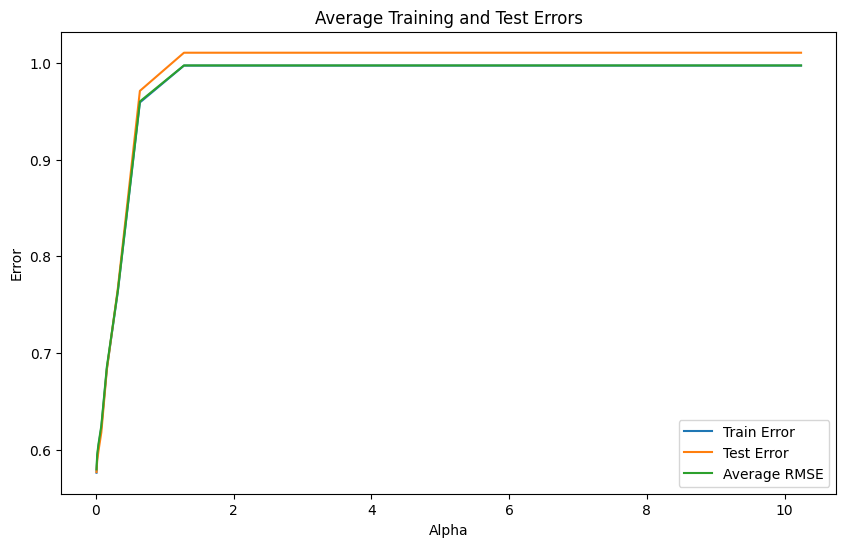

Alpha: 0.01
Coefficients: [-0.05575201  0.          0.07838342  0.74983518 -0.34118717  0.
 -0.0366328   0.          0.03026607  0.12792475  0.09705018  0.0283269
  0.39315643  0.          0.         -0.25585755  0.01027875]
Intercept: 0.003517566538608111
Alpha: 0.02
Coefficients: [-0.04678089  0.          0.05540729  0.417895   -0.         -0.
 -0.0235775   0.          0.01991456  0.12342224  0.09834909  0.01451177
  0.38211529  0.          0.         -0.24260772  0.00395461]
Intercept: 0.0033493865873946366
Alpha: 0.04
Coefficients: [-0.         -0.          0.02265182  0.38816993  0.         -0.
 -0.          0.          0.          0.10967615  0.09765851  0.
  0.37292906  0.          0.         -0.19767095  0.        ]
Intercept: 0.002869825767779808
Alpha: 0.08
Coefficients: [-0.          0.          0.          0.38657731  0.         -0.
 -0.          0.          0.          0.07795866  0.0910618   0.
  0.31912688  0.          0.         -0.12278046  0.        ]
Intercept: 0.002

In [185]:
# Miejsce na kod
# standardize features
from sklearn import preprocessing
X_scaled = preprocessing.scale(sales[all_features])
y_scaled = preprocessing.scale(sales['price'])


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2)
alphas = np.array([0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.24])
average_rmse = []
train_errors = []
test_errors = []
models = {}
# model_all = linear_model.Lasso(alpha=5e2 )
# model_all.fit(sales[all_features], sales['price'])

for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha)
    # cross validation
    scores = cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    # if alpha == 0.04:
    #     print(f'Alpha: {alpha}')
    #     print(f'Average RMSE: {math.sqrt(-np.mean(scores))}')
    #     print(f'Coefficients: {lasso.fit(X_train, y_train).coef_}')
    #     print(f'Intercept: {lasso.fit(X_train, y_train).intercept_}')
    
    print(f'Alpha: {alpha}')
    print(f'Average RMSE: {math.sqrt(-np.mean(scores))}')
    average_rmse.append(math.sqrt(-np.mean(scores)))
    lasso.fit(X_train, y_train)
    # print(f'Coefficients: {lasso.fit(X_train, y_train).coef_}')
    # print(f'Intercept: {lasso.fit(X_train, y_train).intercept_}')
    print(f"Training RMSE: {math.sqrt(np.mean((lasso.predict(X_train) - y_train)**2))}")
    train_errors.append(math.sqrt(np.mean((lasso.predict(X_train) - y_train)**2)))
    print(f"Test RMSE: {math.sqrt(np.mean((lasso.predict(X_test) - y_test)**2))}")
    test_errors.append(math.sqrt(np.mean((lasso.predict(X_test) - y_test)**2)))
    
    models[alpha] = {'coefficients': lasso.fit(X_train, y_train).coef_, 'intercept': lasso.fit(X_train, y_train).intercept_}

# Plot average RMSE as a function of the regularization parameter

plt.figure(figsize=(10, 6))
plt.plot(alphas, train_errors, label='Train Error')
plt.plot(alphas, test_errors, label='Test Error')
plt.plot(alphas, average_rmse, label='Average RMSE')
plt.xlabel('Alpha')
plt.ylabel('Error')
plt.title('Average Training and Test Errors')
plt.legend()
plt.show()

for key, value in models.items():
    print(f"Alpha: {key}")
    print(f"Coefficients: {value['coefficients']}")
    print(f"Intercept: {value['intercept']}")
    

**Pytania:**
1. Jaką wartość parametru $\lambda$ wybrałbyś/wybrałabyś dla naszego modelu ?
2. Które z cech, dla ustalonej wartości parametru $\lambda$ wchodzą w skład modelu - podaj w kolejności od najbardziej znaczących cech ?

In [182]:
# Miejsce na kod
# Wedlug powyzszego kodu podczas walidacji krzyzowej najmniejszy blad osiagnal model z parametrem alpha = 0.01
Coefficients = [-0.06325063, -0. ,         0.07204063,  0.72147621 ,-0.29939081 , 0.-0.04587125 , 0.  ,        0.03071097 , 0.12760324 , 0.09208758 , 0.03252697,  0.38697811 , 0.     ,     0.     ,    -0.25485823 , 0.01183906]
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']
sorted_features = sorted(zip(all_features, Coefficients), key=lambda x: abs(x[1]), reverse=True)
sorted_features = [feature for feature, coef in sorted_features if coef != 0]
sorted_features
# Najbardziej znaczace cechy w kolejnosci od najbardziej znaczacych cech
# 'sqft_living', 'condition', 'sqft_living_sqrt', 'sqft_basement', 'floors_square', 'waterfront', 'bathrooms', 'bedrooms', 'sqft_lot', 'view', 'floors', 'yr_built'



['sqft_living',
 'condition',
 'sqft_living_sqrt',
 'sqft_basement',
 'floors_square',
 'waterfront',
 'bathrooms',
 'bedrooms',
 'sqft_lot',
 'view',
 'floors',
 'yr_built']